### **1) Import Libraries**

In [1]:
# installing the packages  to visualize the keras model
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install librosa

In [3]:
# install the pakcage to create a table
!pip install tabulate

In [4]:
# model visualizer
import visualkeras

In [5]:
%pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.9 MB/s eta 0:00:00


In [55]:
# Do not delete these imports
from Preprocessing import *
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa.display
from sklearn.preprocessing import LabelEncoder
# Audio things
# ------------
import librosa.display
from IPython.display import Image
from numpy import ndarray as NDArray
# Neural network things
# ---------------------
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D,MaxPooling2D, Add, Conv2D, MaxPool1D, Conv1D, Input, BatchNormalization, Dropout
from keras.layers import Input, Conv2D, BatchNormalization, Activation, DepthwiseConv2D, GlobalAveragePooling2D, Reshape, Dropout, Dense
from keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Other things
# -------------
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
import seaborn as sns
from scipy import signal
import numpy as np
import scipy
import matplotlib.pyplot as plt
!pip install SoundFile
!pip install yattag
from IPython.display import Audio
import pandas as pd
import math
import random
import pandas as pd
from itertools import count
from xml.dom import minidom
from yattag import Doc, indent
import os
# Table
from tabulate import tabulate
# Image
from IPython.display import display, HTML
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model


In [7]:
colab = True

In [9]:
# This snippet of code can take up to 5 minutes or so.
# Plase allow this to complete.
if colab:
    !pip install SoundFile
    from google.colab import drive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    import zipfile

    # Google Authentication
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    # Download code files
    downloaded = drive.CreateFile({'id':"1js1fz4Bu98NIds4cErL7NdT1efxavixp"})
    downloaded.GetContentFile('Code.zip')

    # Extract files to temporary location in Google Drive
    with zipfile.ZipFile('Code.zip', 'r') as zip_file:
        zip_file.extractall()

    # Download data files
    downloaded = drive.CreateFile({'id':"16_ABjuGGDzlu6F67hoy0FLKtHjsWASPa"})
    downloaded.GetContentFile('Data.zip')

    # Extract files to temporary location in Google Drive
    with zipfile.ZipFile('Data.zip', 'r') as zip_file:
        zip_file.extractall()

### **2) Pre-process the data**

---



In [2]:
# Name for the presence and absence class based on how the data was annotated
# in sonicvisualiser
# -----------------------------
positive_class = ['1'] # which labels should be bundled together for the positive  class
negative_class = ['0'] # which labels should be bundled together for the negative  class

# Data hyper-parameters
# -----------------------------
# 1000, 5000, 10000 hz Cutt off for low pass filter were used
lowpass_cutoff = 10000
# Frequency to downsample to
downsample_rate =  22050
nyquist_rate = 22050 / 2 # Nyquist rate (half of sampling rate)
segment_duration = 4 # how long should a segment be


# Spectrogram hyper-parameters
# -----------------------------
n_fft = 1024 # Hann window length
hop_length = 256 # Sepctrogram hop size
n_mels = 128 # Spectrogram number of mells
f_min = 4000 # Spectrogram, minimum frequency for call
f_max = 9000 # Spectrogram, maximum frequency for call

# Don't change these
# -----------------------------
species_folder = '/content/Data/' # Should contain /Audio and /Annotations, don't change this
file_type = 'svl' # don't change this
audio_extension = '.wav' # don't change this

### **Processing the data**

---



In [3]:
# This takes about 1 minute
pre_pro = Preprocessing(species_folder, lowpass_cutoff,
                downsample_rate, nyquist_rate,
                segment_duration,
                positive_class, negative_class,n_fft,
                hop_length, n_mels, f_min, f_max, file_type,
                audio_extension)

X, Y = pre_pro.create_dataset(False)

# We save the pickle X and y variables to disk so that we don't have to
# pre-process the data everytime we want to train a model
pre_pro.save_data_to_pickle(X, Y)

# These are saved to /Saved_Data/ by the way.

print ('done')

Processing: 15_audio_50
Found file
Filtering...
Downsampling...
15_audio_50
Reading annotations...
Processing: 20_092132
Processing: 6_2-2-2024=14_48_2
Found file
Filtering...
Downsampling...
6_2-2-2024=14_48_2
Reading annotations...
Processing: 6_2-2-2024=14_48_31
Found file
Filtering...
Downsampling...
6_2-2-2024=14_48_31
Reading annotations...
Processing: 28_2-2-2024=14_42_43
Found file
Filtering...
Downsampling...
28_2-2-2024=14_42_43
Reading annotations...
Processing: 24_2-2-2024=14_47_21
Found file
Filtering...
Downsampling...
24_2-2-2024=14_47_21
Reading annotations...
Processing: 3_2-2-2024=22_0_31
Found file
Filtering...
Downsampling...
3_2-2-2024=22_0_31
Reading annotations...
Processing: 28_2-2-2024=14_45_32
Found file
Filtering...
Downsampling...
28_2-2-2024=14_45_32
Reading annotations...
Processing: 28_2-2-2024=14_43_47
Found file
Filtering...
Downsampling...
28_2-2-2024=14_43_47
Reading annotations...
Processing: 7_030224-101338
Processing: 14_2-2-2024=19_41_13
Found fil

In [ ]:
print(X.shape)
print(Y.shape)

(2047, 88200)
(2047,)


### **3) preprocessing**

---



**3.1) Augmentation**

**3.1.1) CLip Distortion**

<p align="justify">The mechanism behind clip distortion noise augmentation involves adding artificial distortion or noise to audio clips. </p>

<p align="justify">Amplitude modulation involves multiplying the audio signal by a modulating signal to change its amplitude, which can introduce clipping distortion if the amplitude exceeds the maximum allowable level. Frequency modulation involves changing the frequency of the audio signal over time, which can create frequency distortions or artifacts in the audio waveform. Adding random noise signals involves superimposing random noise of varying intensity onto the original audio signal, simulating background noise or interference. </p>

<p align="justify">By introducing such distortions or noise to the training data, the machine learning model learns to adapt to these variations and becomes more robust to real-world scenarios where audio may be corrupted or distorted. This augmentation technique helps improve the model's generalization ability, allowing it to perform better on unseen or noisy audio data by learning to ignore irrelevant variations while focusing on the underlying patterns in the audio signals.</p>

In [ ]:
# method interface
def augment_clip(signal, minm=10, maxm=40): pass

**3.1.2) Polarity Inversion**

<p align="justify">    Flip the audio samples upside-down, reversing their polarity. In other words, multiply the
    waveform by -1, so negative values become positive, and vice versa. The result will sound
    the same compared to the original when played back in isolation. However, when mixed with
    other audio sources, the result may be different. This waveform inversion technique
    is sometimes used for audio cancellation or obtaining the difference between two waveforms.
    However, in the context of audio data augmentation, this transform can be useful when
    training phase-aware machine learning models.

In [ ]:
def _augment_clip(signal, minm=10, maxm=40):
    """
    Clipping Distortion: Augmentation
    =================================
    The percentage of points that will be clipped is drawn from a uniform distribution between
    the two input parameters min_percentile_threshold and max_percentile_threshold. If for instance
    30% is drawn, the samples are clipped if they're below the 15th or above the 85th percentile.
    """
    random_percent = np.random.uniform(minm, maxm)
    # Calculate the threshold values for clipping
    clip_min = np.percentile(signal, (100 - random_percent) / 2)
    clip_max = np.percentile(signal, (100 + random_percent) / 2)
    return np.clip(signal, clip_min, clip_max)

In [ ]:
# method interface
def polarity_inversion(audio): return -audio

#### **Task 1: Function to convert audio to spectrogram**

In [4]:
def _normilize(audio):
    min, max = np.min(audio), np.max(audio)
    normilized = (audio - min) / (max - min)
    return normilized

In [5]:
# function to read over the wav file and return the audion and the sampling rate
def read_audio(file, sr=4800):
    audio, sr = librosa.load(file, sr=sr)
    return audio, sr

In [6]:
def audio_to_spectrogram(audio):
    # Compute the Mel spectrogram and apply normalization
    mel_spectg = librosa.feature.melspectrogram(y=audio)
    mel_spectg_db = librosa.power_to_db(mel_spectg, ref=np.max)
    # Apply normalization (you can customize this based on your needs)
    normilized = _normilize(mel_spectg_db)
    return normilized

**function used to visualize the normilized 3 gibbon and non-gibbon samples**

In [ ]:
def visualize(signals, labels, Y):
    fig, axes = plt.subplots(2, 3, figsize=(9, 5))
    # Plot three gibbon presence events
    for i, indices in enumerate(labels):
      for j, idx in enumerate(indices):
          # generate the spectrogram
          spectrogram = audio_to_spectrogram(signals[idx])
          # spectrogram = polarity_inversion(spectrogram)
          # plot the generated spectrogram
          # axes.colorbar(format='%+2.0f dB')
          librosa.display.specshow(spectrogram, x_axis='time', sr=downsample_rate, hop_length=256, ax=axes[i, j])
          axes[i, j].set_title(f"{Y[idx]}")
          axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

**Task 2: Visualize three Gibbons and Non-Gibbons**

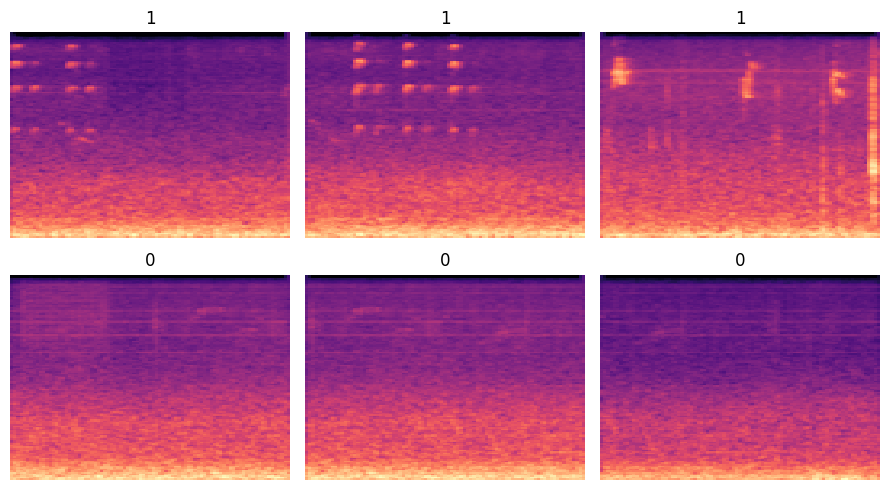

In [ ]:
# testing the function
# the first array contains the positvie example
# the second one the negative
labels = [[5, 6, 100], [0, 1, 2]]
visualize(X, labels, Y)

**Task 3: Given the values above, how many gibbon examples and no-gibbon examples would you like to have? You don't have to write anything down, just reflect on this.**

In [24]:
unique, counts = np.unique(Y, return_counts=True)
original_distribution = dict(zip(unique, counts))
print('Data distribution:',original_distribution)

Data distribution: {'0': 265, '1': 1305}


<p align="justify">The proportion of positive and negative classes in a deep learning classifier depends on various factors, including the nature of the problem, the distribution of classes in the dataset, and the desired outcome. There is no fixed rule for determining the exact proportion, as it varies from one application to another.

However, a balanced dataset, where the number of instances for each class is roughly equal, is often preferred to prevent the model from being biased towards the majority class. In cases where there is a significant class imbalance, techniques such as oversampling the minority class, undersampling the majority class, or using specialized loss functions can be employed to address the imbalance. <b>In my case I prefered balanced class. </b>

### **4) Trainer Pipeline**

<p align="justify"> The TrainerPipeline class simplifies the machine learning model training process by integrating essential functionalities. Upon initialization, it stores the model and initializes placeholders for training history. Through methods like create_train_test_split, it divides the data for training and testing, while train_model executes the training with customizable parameters. Finally, plot_history provides visual insights into the model's performance, plotting accuracy and loss metrics. This compact yet comprehensive class streamlines model development, enhancing productivity and effectiveness.

##### **4.1) Task 4:Data manipulator**

It provides all the data preprocessing steps ready for to train the model. This includes new presence and absence creation, augmentation and normilzation. <B>put the new example generator functions inside the Dataset pipeline class. I merge some of the function with given the condition ('gibbon' or 'non-gibbon') to make them more managable.

In [7]:
class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.new_presence = []
        self.new_absence = []

    def _augment_clip(self, signal, minm=10, maxm=40):
        """
        Clipping Distortion: Augmentation
        =================================
        The percentage of points that will be clipped is drawn from a uniform distribution between
        the two input parameters min_percentile_threshold and max_percentile_threshold. If for instance
        30% is drawn, the samples are clipped if they're below the 15th or above the 85th percentile.
        """
        random_percent = np.random.uniform(minm, maxm)
        # Calculate the threshold values for clipping
        clip_min = np.percentile(signal, (100 - random_percent) / 2)
        clip_max = np.percentile(signal, (100 + random_percent) / 2)
        return np.clip(signal, clip_min, clip_max)

    def _polarity_inversion(self, audio):
        """
        Polarity Inversion: Augmentation
        ================================
        The function to reverse all the the data upside down

        Return the negative of the original data. Its importance is reflected on the above sections
        """
        return -audio

    def preprocess(self, new_example=True, quantity=None):
        """
        Function to preprocess the data

        This include new example creation, augmentation and normilization
        """
        # If genearate the new example is "True" and append them to original data
        if quantity is None:
            quantity = [100, 200]
        if new_example:
            # when this function called it will combine the original
            # data with the new examples
            self.generate_new_spectrograms(quantity)
            # generate the data with the absence
            self.generate_new_spectrograms(quantity, presence=False)
        # apply augmentation on each of the datapoint
        augmented = []
        for audio in self.X:
            # convert the audio and normilize
            s_db = audio_to_spectrogram(audio)
            # apply clip distortion augmnetation
            clip = self._augment_clip(s_db)
            # apply polarity inversion augmnetation
            invert = self._polarity_inversion(s_db)
            # add a dimension for the tensorflow model (tensorflow expects channel dimension)
            s_db, clip, invert = s_db[:, :, np.newaxis], clip[:, :, np.newaxis], invert[:, :, np.newaxis]
            # concatenate original and the other two augmneted datapoint into the last dimension
            _augmnent = np.concatenate((s_db, clip, invert), axis=-1)
            # collected the augmented data to the list
            augmented.append(_augmnent)
        return np.array(augmented), self.y

    def create_train_test_split(self, data, test_size=0.0, random_state=42):
        """
        Function to split the data into training and testing sets.
        """
        # Create the label encode instances
        call_order = ['0', '1']
        # Converting categorical string labels ('gibbons' and 'no-gibbon) to 1s and 0s
        for index, call_type in enumerate(call_order):
            self.y = np.where(self.y == call_type, index, self.y)
        # convert the label to categorical
        label = to_categorical(self.y, num_classes=2)
        # split the data in to train and test
        X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=test_size, random_state=random_state, shuffle=True)
        return X_train, X_test, y_train, y_test

    def randomly_select_spectrogram(self, label):
        if label == '1':
            indices = np.where(self.y == '1')[0]
        else:
            indices = np.where(self.y == '0')[0]
        # randomly generate the index
        idx = np.random.randint(0, len(indices))
        return self.X[indices[idx]], idx

    def generate_new_spectrograms(self, quantity, presence=True):
        # quantity: [ presence, ansence ]
        # _ indicates internal newly generated datas
        _spectrogram, _targets = [], []

        if presence:
          for i in range(quantity[0]):
            # select spec randomly
            selected_spectrogram, idx = self.randomly_select_spectrogram('1')
            _spectrogram.append(selected_spectrogram)
            _targets.append('1')
          # append it to the class presence acumulator variable
          self.new_presence.append(_spectrogram)
        else:
          for i in range(quantity[1]):
            # select spec randomly
            selected_spectrogram, idx = self.randomly_select_spectrogram('0')
            _spectrogram.append(selected_spectrogram)
            _targets.append('0')
          # append it to the clas absence acummulator variable
          self.new_absence.append(_spectrogram)
        # Concatenate the newly formed data
        self.X = np.concatenate((self.X, _spectrogram), axis=0)
        self.y = np.concatenate((self.y, np.array(_targets)), axis=0)
        return _spectrogram, np.array(_targets)


**<small>Creating the dataset from the above pipeline**

In [8]:
# Creating the dataset instance
dataset = Dataset(X, Y)
# Preprocess the data
# We can set new_exmple option set to False to stop genrating new examples
X_processed, y_processed = dataset.preprocess(quantity=[1, 1041])
print(X_processed.shape)
# Sllit the data to train and val (test)
X_train, X_test, y_train, y_test = dataset.create_train_test_split(X_processed, test_size=0.2, random_state=42)

(2612, 128, 173, 3)


In [ ]:
#del X_train, X_test, y_train, y_test

In [ ]:
X_train.shape

(3888, 128, 94, 3)

**<small>Visualizing the new created example for the presence and the absence**

In [9]:
#del dataset.new_presence, dataset.new_absence

In [10]:
#del X, Y, X_processed, y_processed

In [ ]:
def get_data(data):
  # daa: presence or absence
  # lets randomly pick the data
  idx = np.random.randint(len(data[0]))
  data = data[0][idx]
  return data

In [ ]:
def visualize(signals):
    fig, axes = plt.subplots(figsize=(4, 4))
    # generate the spectrogram
    spectrogram = audio_to_spectrogram(signals)
    # plot the generated spectrogram
    librosa.display.specshow(spectrogram)

In [ ]:
# get data for presence radomly
data = get_data(dataset.new_presence)

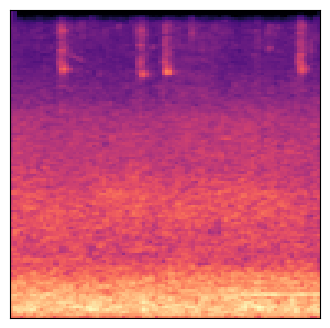

In [ ]:
# visualize the newly generated presence data
visualize(data)

In [ ]:
# get data for absence radomly
data = get_data(dataset.new_absence)

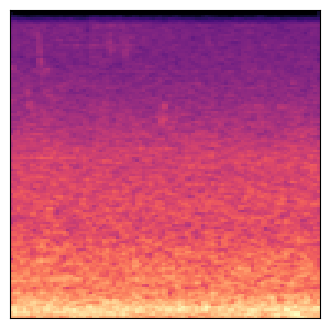

In [ ]:
# visualize the newly generated absence data
visualize(data)

##### **4.2) Pipeline for training**

In [11]:
class TrainerPipeline:
    """ A Traning Pipeline """
    def __init__(self, model):
        self.model = model
        self.history = None

    def train_model(self, model, X_train, y_train, epochs=5, validation_split=0.2, batch_size=32):
        """
        Function to train the model.
        """
        self.model = model
        self.history = self.model.fit(X_train, y_train, epochs=epochs,
                        validation_split=validation_split, batch_size=batch_size)

    def train_pipeline(self, X_train, y_train, model, epochs=5, validation_split=0.2, batch_size=32):
        """
        Trainer pipeline to handle training and visualization.
        """
        self.train_model(model, X_train, y_train, epochs, validation_split, batch_size)

    def save_model(self, filename):
        """
        Function to save the trained model.
        """
        self.model.save(filename)

    def plot_history(self):
        """
        Function to plot the training and validation history.
        """
        metrics = ['accuracy', 'loss']
        fig = plt.figure(figsize=(10, 6))

        for i, metric in enumerate(metrics, 1):
            ax = fig.add_subplot(1, 2, i)
            ax.plot(self.history.history[metric])
            ax.plot(self.history.history['val_' + metric])
            ax.set_title('Model ' + metric.capitalize())
            ax.set_ylabel(metric.capitalize())
            ax.set_xlabel('Epoch')
            ax.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()


**Define the function to calculate model performance metrics such as accuracy, precision, F1 Score and Recall.**

In [52]:
def evaluate_model(X_test, y_test, model, types):
    # Step 1: Make predictions on your test data
    y_pred = model.predict(X_test)
    # Assuming that for binary classification, you need to convert probabilities to class labels
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Step 2: Generate confusion matrix
    conf_matrix = multilabel_confusion_matrix(y_test, y_pred_classes)

    # Step 3: Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='macro')
    recall = recall_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')

    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    TN = conf_matrix[0, 0]
    TP = conf_matrix[1, 1]

    FNR = FN / (FN + TP)
    FPR = FP / (FP + TN)

    metrics = {types:{
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1}
    }

    return metrics


#### **4.1) Building and Training the 2D Model**

<p align="justify">This convolutional neural network (CNN) architecture consists of three convolutional layers followed by max-pooling layers for downsampling. Each convolutional layer applies a 2x2 filter with ReLU activation to extract features from the input. Max-pooling layers with a 2x2 pool size reduce the spatial dimensions of the feature maps. After the convolutional layers, the feature maps are flattened into a vector and fed into a dense layer with 30 units and ReLU activation. Finally, a dense layer with softmax activation produces output probabilities for two classes.

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

The input shape were different for different kinds of down sampling rate. Different kinds of down sampling rate were used for computational resources reason. Down sampling rate of 9600hz gives

```
(128, 94, 3) 22,050hz gives (128, 173, 3)
```



In [14]:
X_train.shape

(2089, 128, 173, 3)

In [12]:
INPUT_SHAPE = (128, 173, 3)

#### **There four types of model used for trainig over the dataset**

##### **1) MobileNet Model**

In [44]:

def _conv_block(inputs, filters, kernel, strides):
    x = Conv2D(filters, kernel_size=kernel, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def _depthwise_conv_block(inputs, pointwise_conv_filters, depth_multiplier=1, strides=(1, 1), block_id=1):
    if strides == (1, 1):
        x = inputs
    else:
        x = _conv_block(inputs, pointwise_conv_filters, (1, 1), strides)

    x = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=depth_multiplier, strides=strides, name='conv_dw_%d' % block_id)(x)
    x = BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = Activation('relu')(x)

    x = Conv2D(pointwise_conv_filters, (1, 1), padding='same', strides=(1, 1), name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    x = Activation('relu')(x)

    return x

def SmallMobileNet(input_shape=(128, 94, 3), alpha=0.25, depth_multiplier=1, dropout=1e-3):
    inputs = Input(shape=input_shape)

    first_filters = 64
    x = _conv_block(inputs, first_filters, (3, 3), strides=(2, 2))

    x = _depthwise_conv_block(x, int(64 * alpha), depth_multiplier, block_id=1)
    x = _depthwise_conv_block(x, int(128 * alpha), depth_multiplier, strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, int(128 * alpha), depth_multiplier, block_id=3)
    x = _depthwise_conv_block(x, int(256 * alpha), depth_multiplier, strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, int(256 * alpha), depth_multiplier, block_id=5)

    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, int(256 * alpha)))(x)
    x = Dropout(dropout)(x)
    x = Conv2D(2, (1, 1), padding='same')(x)
    x = Activation('sigmoid')(x)
    x = Reshape((2,))(x)

    model = Model(inputs, x)

    return model

model = SmallMobileNet(input_shape=(128, 173, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 173, 3)]     0         
                                                                 
 conv2d_46 (Conv2D)          (None, 64, 87, 64)        1792      
                                                                 
 batch_normalization_46 (Ba  (None, 64, 87, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_53 (Activation)  (None, 64, 87, 64)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 87, 64)        640       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 87, 64)        256 

**Traing MobileNet V1 Model**

I tarined the network 3 times on a row and the evaluated code below is captured the first run which was the best among the three.

Epoch 1/5
53/53 [==============================] - 51s 787ms/step - loss: 0.5797 - accuracy: 0.6697 - val_loss: 0.6974 - val_accuracy: 0.5191
Epoch 2/5
53/53 [==============================] - 43s 816ms/step - loss: 0.4340 - accuracy: 0.8001 - val_loss: 0.7518 - val_accuracy: 0.5191
Epoch 3/5
53/53 [==============================] - 40s 756ms/step - loss: 0.3497 - accuracy: 0.8474 - val_loss: 0.9843 - val_accuracy: 0.5191
Epoch 4/5
53/53 [==============================] - 41s 767ms/step - loss: 0.2793 - accuracy: 0.8923 - val_loss: 1.5669 - val_accuracy: 0.5191
Epoch 5/5
53/53 [==============================] - 40s 766ms/step - loss: 0.2254 - accuracy: 0.9072 - val_loss: 2.4778 - val_accuracy: 0.5191


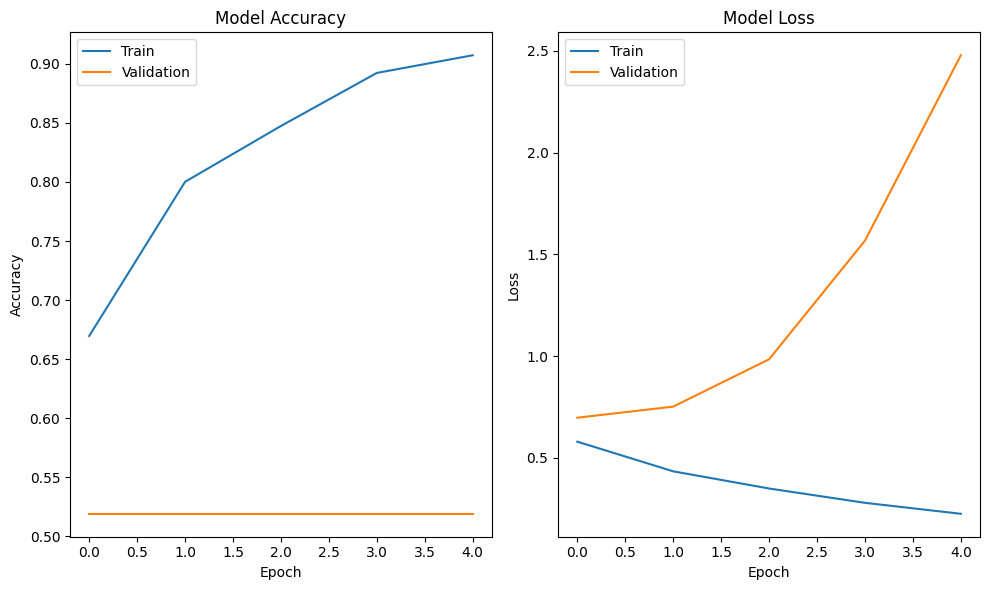

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
# create instance of the training pipeline
trainer = TrainerPipeline(model=None)
# Train-test split and model training
trainer.train_pipeline(X_train, y_train, model, epochs=5, validation_split=0.2, batch_size=32)
# Plot the training history
trainer.plot_history()
# Load the trained model
model = trainer.model
# save the model
trainer.save_model('best_model_3_small_negative_resnet.h5')

**Evaluate the model**

In [41]:
# evaluate the model
evaluate_model(X_test, y_test, model, 'MobileNet')

{'MobileNet': {'Accuracy': 0.6121,
  'F1': 0.729,
  'Precision': 0.9261,
  'Recall': 0.6126}}

####**3) ResNe-10**

In [48]:
def residual_block(input_tensor, filters, strides=(1, 1), use_shortcut=True):
    shortcut = input_tensor
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    if use_shortcut:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def build_resnet10(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, strides=(2, 2))
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, strides=(2, 2))
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, strides=(2, 2))
    x = residual_block(x, filters=512)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=x)
    return model

input_shape = (128, 128, 3)
num_classes = 10
resnet10_model = build_resnet10(input_shape, num_classes)
resnet10_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_100 (Conv2D)         (None, 64, 64, 64)           9472      ['input_8[0][0]']             
                                                                                                  
 batch_normalization_99 (Ba  (None, 64, 64, 64)           256       ['conv2d_100[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_101 (Activation  (None, 64, 64, 64)           0         ['batch_normalization_99

####**4) Efficient Net**

In [24]:
def efficientnet_small(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    num_filters = 32
    for _ in range(4):
        x = _efficientnet_block(x, num_filters)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

def _efficientnet_block(inputs, num_filters):
    x = Conv2D(num_filters, kernel_size=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters * 4, kernel_size=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 173, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 87, 32)        896       
                                                                 
 batch_normalization_13 (Ba  (None, 64, 87, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_13 (Activation)  (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 44, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 44, 32)        1056

**Compile the model**

In [29]:
input_shape = (128, 173, 3)
num_classes = 2
model = efficientnet_small(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 173, 3)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 87, 32)        896       
                                                                 
 batch_normalization_26 (Ba  (None, 64, 87, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_26 (Activation)  (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 44, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 44, 32)        1056

Epoch 1/6
53/53 [==============================] - 89s 2s/step - loss: 0.5403 - accuracy: 0.7193 - val_loss: 0.7238 - val_accuracy: 0.5191
Epoch 2/6
53/53 [==============================] - 118s 2s/step - loss: 0.3675 - accuracy: 0.8390 - val_loss: 1.1501 - val_accuracy: 0.5191
Epoch 3/6
53/53 [==============================] - 76s 1s/step - loss: 0.3073 - accuracy: 0.8731 - val_loss: 1.8252 - val_accuracy: 0.5191
Epoch 4/6
53/53 [==============================] - 72s 1s/step - loss: 0.2397 - accuracy: 0.8995 - val_loss: 2.2899 - val_accuracy: 0.5191
Epoch 5/6
53/53 [==============================] - 72s 1s/step - loss: 0.2035 - accuracy: 0.9138 - val_loss: 3.1634 - val_accuracy: 0.5191
Epoch 6/6
53/53 [==============================] - 69s 1s/step - loss: 0.1964 - accuracy: 0.9264 - val_loss: 3.7505 - val_accuracy: 0.5191


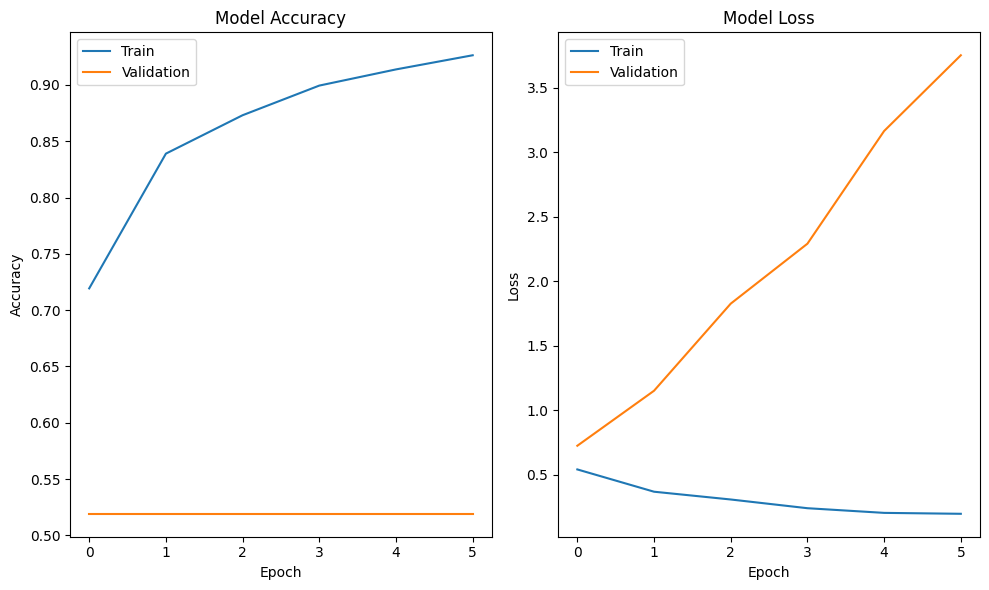

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# create instance of the training pipeline
trainer = TrainerPipeline(model)
# Train-test split and model training
trainer.train_pipeline(X_train, y_train, model, epochs=6, validation_split=0.2, batch_size=32)
# Plot the training history
trainer.plot_history()
# Load the trained model
model = trainer.model
# save the model
trainer.save_model('best_model_3_small_negative_efficient.h5')

In [53]:
evaluate_model(X_test, y_test, model, 'EfficientNet')

{'EfficientNet': {'Accuracy': 0.4912,
  'F1': 0.712,
  'Precision': 0.6932,
  'Recall': 0.6832}}

**3) Best 2D simple architectures**

I have ran this model 2 times and I have got the best result among all

Epoch 1/10
98/98 [==============================] - 72s 718ms/step - loss: 0.6942 - accuracy: 0.5418 - val_loss: 0.6831 - val_accuracy: 0.5257
Epoch 2/10
98/98 [==============================] - 64s 654ms/step - loss: 0.6039 - accuracy: 0.6650 - val_loss: 0.6246 - val_accuracy: 0.7185
Epoch 3/10
98/98 [==============================] - 71s 731ms/step - loss: 0.4427 - accuracy: 0.8129 - val_loss: 0.4349 - val_accuracy: 0.8033
Epoch 4/10
98/98 [==============================] - 66s 671ms/step - loss: 0.3725 - accuracy: 0.8495 - val_loss: 0.4799 - val_accuracy: 0.7956
Epoch 5/10
98/98 [==============================] - 65s 660ms/step - loss: 0.3585 - accuracy: 0.8601 - val_loss: 0.3579 - val_accuracy: 0.8805
Epoch 6/10
98/98 [==============================] - 65s 660ms/step - loss: 0.3026 - accuracy: 0.8849 - val_loss: 0.3231 - val_accuracy: 0.8612
Epoch 7/10
98/98 [==============================] - 63s 647ms/step - loss: 0.2807 - accuracy: 0.8887 - val_loss: 0.2834 - val_accuracy: 0.8843

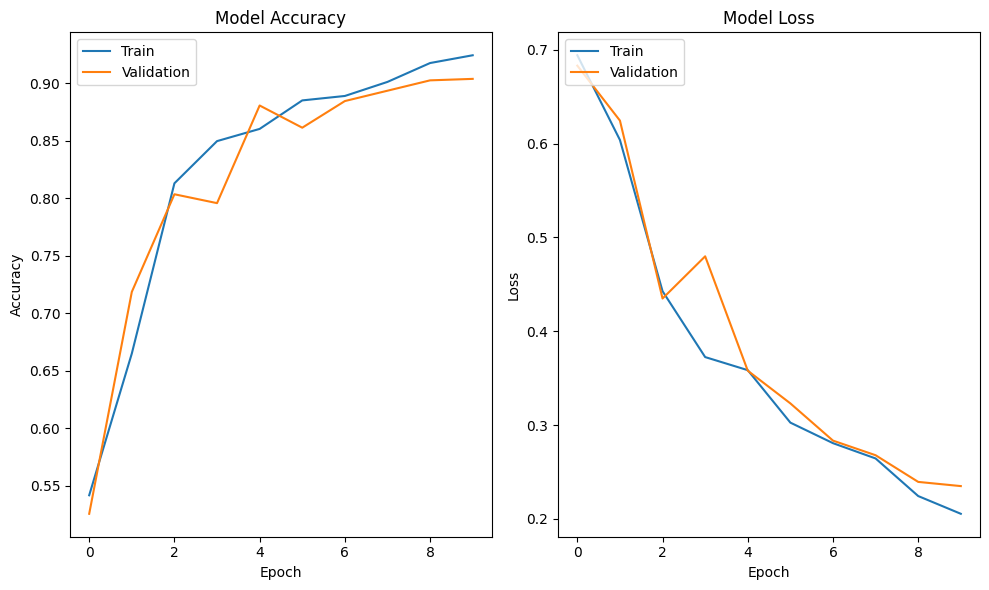

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# create instance of the training pipeline
trainer = TrainerPipeline(model=None)
# Train-test split and model training
trainer.train_pipeline(X_train, y_train, model, epochs=10, validation_split=0.2, batch_size=32)
# Plot the training history
trainer.plot_history()
# Load the trained model
model = trainer.model
# save the model
trainer.save_model('best_model_last.h5')

**Evaluation matrics**

In [22]:
# evaluate the model
evaluate_model(X_test, y_test, model, '2D CNN')

{'2D CNN': {'Accuracy': 0.9053,
  'F1': 0.8202,
  'Precision': 0.9057,
  'Recall': 0.9054}}

**Best model 2**

**This model was also perform better but at the end of the epoch it starts to overfit.**

Epoch 1/10
67/67 [==============================] - 9s 45ms/step - loss: 0.6456 - accuracy: 0.6222 - val_loss: 0.5426 - val_accuracy: 0.6957
Epoch 2/10
67/67 [==============================] - 2s 25ms/step - loss: 0.5233 - accuracy: 0.7409 - val_loss: 0.4633 - val_accuracy: 0.7864
Epoch 3/10
67/67 [==============================] - 2s 27ms/step - loss: 0.4507 - accuracy: 0.7901 - val_loss: 0.3903 - val_accuracy: 0.8336
Epoch 4/10
67/67 [==============================] - 2s 27ms/step - loss: 0.3424 - accuracy: 0.8586 - val_loss: 0.2652 - val_accuracy: 0.8960
Epoch 5/10
67/67 [==============================] - 2s 28ms/step - loss: 0.2478 - accuracy: 0.9017 - val_loss: 0.3403 - val_accuracy: 0.8355
Epoch 6/10
67/67 [==============================] - 2s 27ms/step - loss: 0.2164 - accuracy: 0.9135 - val_loss: 0.1661 - val_accuracy: 0.9376
Epoch 7/10
67/67 [==============================] - 2s 25ms/step - loss: 0.1613 - accuracy: 0.9418 - val_loss: 0.1713 - val_accuracy: 0.9357
Epoch 8/10
67

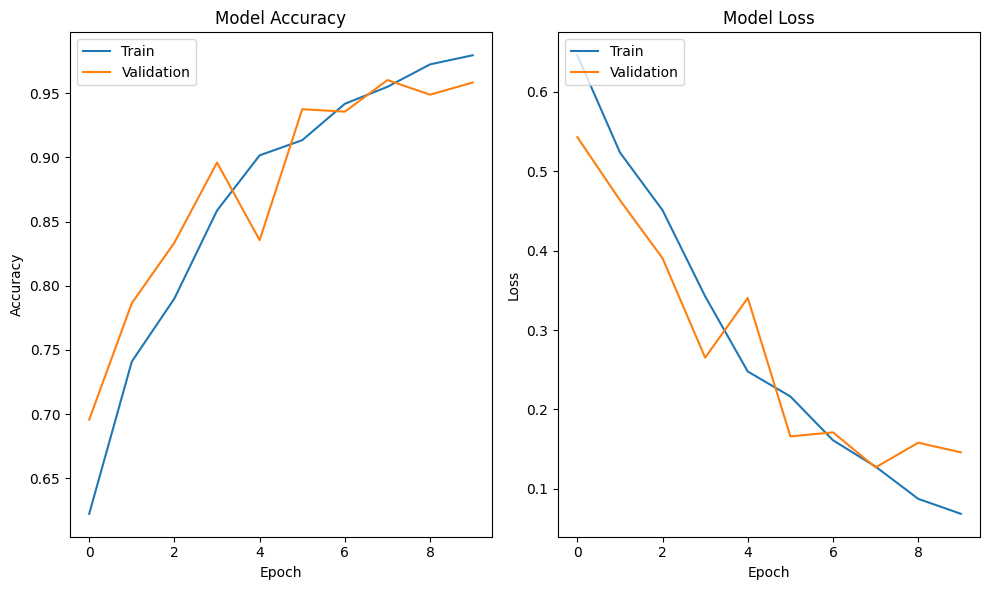

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# create instance of the training pipeline
trainer = TrainerPipeline(model=None)
# Train-test split and model training
trainer.train_pipeline(X_train, y_train, model, epochs=10, validation_split=0.2, batch_size=32)
# Plot the training history
trainer.plot_history()
# Load the trained model
model = trainer.model
# save the model
trainer.save_model('best_model_last_2.h5')

##### **4) 2D Model with Batch Normilization and without augmentation**

In [ ]:
def Mel2DConv():
    # create a conv neural network
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = Mel2DConv()

Epoch 1/10
193/193 [==============================] - 6s 13ms/step - loss: 0.6765 - accuracy: 0.5441 - val_loss: 0.7865 - val_accuracy: 0.4942
Epoch 2/10
193/193 [==============================] - 1s 7ms/step - loss: 0.6604 - accuracy: 0.5781 - val_loss: 0.6920 - val_accuracy: 0.5337
Epoch 3/10
193/193 [==============================] - 2s 8ms/step - loss: 0.6490 - accuracy: 0.6064 - val_loss: 0.6558 - val_accuracy: 0.5926
Epoch 4/10
193/193 [==============================] - 2s 10ms/step - loss: 0.6257 - accuracy: 0.6550 - val_loss: 0.6368 - val_accuracy: 0.6347
Epoch 5/10
193/193 [==============================] - 1s 7ms/step - loss: 0.5835 - accuracy: 0.7072 - val_loss: 0.5923 - val_accuracy: 0.7001
Epoch 6/10
193/193 [==============================] - 1s 7ms/step - loss: 0.5337 - accuracy: 0.7441 - val_loss: 0.5466 - val_accuracy: 0.7273
Epoch 7/10
193/193 [==============================] - 1s 8ms/step - loss: 0.4678 - accuracy: 0.7812 - val_loss: 0.5101 - val_accuracy: 0.7694
Epoc

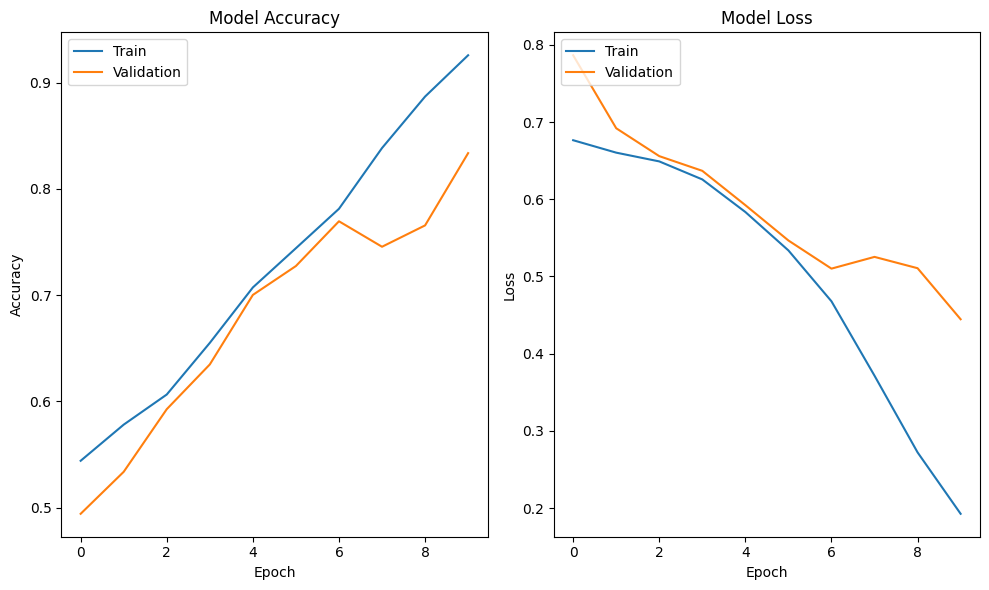

In [ ]:
# create instance of the training pipeline
trainer = TrainerPipeline(model=None)
# Train-test split and model training
trainer.train_pipeline(X_train, y_train, model, epochs=10, validation_split=0.2, batch_size=32)
# Plot the training history
trainer.plot_history()
# Load the trained model
model = trainer.model
# save the model
trainer.save_model('model_2.h5')

**Evaluate the model**

In [39]:
# evaluate the model
evaluate_model(X_test, y_test, model, '2D CNN-No Aug')

{'2D CNN-No Aug': {'Accuracy': 0.8676,
  'F1': 0.801,
  'Precision': 0.792,
  'Recall': 0.821}}

In [ ]:
del trainer

### **5) Evaluation Pipeline**

A complete pipeline to evaluate the model

In [96]:
class EvaluationPipeline:
    def __init__(self, model, path, audio_to_spectrogram, model_path=None):
        if model_path:
            self.model = load_model(model_path)
        else:
            self.model = model
        self.path = path
        # pass the converter function
        self.audio_to_spectrogram = audio_to_spectrogram
        self.preds = []
        # collecting the model output: for accuracy calculation
        self.model_outputs = []

    @classmethod
    def load_from_file(cls, model_path, path, audio_to_spectrogram):
        """
        Method to load EvaluationPipeline from a saved model file.
        """
        return cls(model_path=model_path, path=path, audio_to_spectrogram=audio_to_spectrogram)

    def butter_lowpass(self, cutoff, nyq_freq, order=4):
        normal_cutoff = float(cutoff) / nyq_freq
        b, a = signal.butter(order, normal_cutoff, btype='lowpass')
        return b, a

    def butter_lowpass_filter(self, data, cutoff_freq, nyq_freq, order=4):
        b, a = self.butter_lowpass(cutoff_freq, nyq_freq, order=order)
        y = signal.filtfilt(b, a, data)
        return y

    def downsample_file(self, amplitudes, original_sr, new_sample_rate):
        return librosa.resample(y=amplitudes,
                                orig_sr=original_sr,
                                target_sr=new_sample_rate,
                                res_type='kaiser_fast')

    def predict_on_entire_file(self, audio, sample_rate, lowpass_cutoff,
                               downsample_rate, nyquist_rate):

        # Apply a low pass filter to get rid of high frequency components
        filtered = self.butter_lowpass_filter(audio, lowpass_cutoff, nyquist_rate)
        # Downsample the audio
        amplitudes = self.downsample_file(filtered, sample_rate, downsample_rate)
        # Duration of file
        file_duration = len(amplitudes) / sample_rate
        # Number of segments
        segments = math.floor(file_duration) - 4
        # Store predictions in this list
        predictions, model_outputs  = [], []
        # Loop over the file and work in small "segments"
        for position in range(0, segments):
          # Determine start of segment
          start_position = position
          # Determine end of segment
          end_position = start_position + 4
          print('start position:', start_position)
          print('end position:', end_position)
          # Extract a 4 second segment from the audio file
          audio_segment = amplitudes[start_position * downsample_rate:end_position * downsample_rate]
          # Create the spectrogram
          S = self.audio_to_spectrogram(audio_segment)
          # Reshape the spectrogram to meet model input shape
          S = np.reshape(S, (1, 128, 94, 1))
          # Repeat the data along the channel dimension to match model input
          S = np.repeat(S, 3, axis=-1)
          # Predict using the model
          softmax = self.model.predict(S)
          print(softmax)
          model_outputs.append(softmax)  # Store model output
          # Binary output
          binary_prediction = np.argmax(softmax, -1)
          # Append result
          predictions.append('absence' if binary_prediction[0] == 0 else 'presence')

        # Store model outputs for this file
        self.model_outputs.append(model_outputs)

        return predictions

    def evaluate_files(self, lowpass_cutoff, downsample_rate, nyquist_rate):
        # create a list of files
        files = [line.strip() for line in open("/content/Data/DataFiles/Testfiles.txt", "r").readlines()]
        table = []

        for i, file in enumerate(files):
          print(f'predicting on file name:{file}')
          testfile, sr = librosa.load(f'{self.path}{file}')
          predictions = self.predict_on_entire_file(testfile, sr, lowpass_cutoff, downsample_rate, nyquist_rate)
          self.preds.append(predictions)
          # gibbon counts
          count1 = predictions.count('presence')
          # non-gibbon counts
          count2 = predictions.count('absence')
          total_segments = len(predictions)
          table.append([f'Test {i}', count1, count2, total_segments])

        headers = ["File", "Gabbon (0) Count", "Non-Gabbon (1) Count", "Total Segments"]
        print(tabulate(table, headers=headers, tablefmt="grid"))

    def create_annotation(self, i, low_freq=0, high_freq=10000):
      start_time = []
      end_time = []
      groups = self.group_consecutives(i)
      for group in groups:
          start_time.append(group[0])
          end_time.append(group[-1] + 4)

      df_preds = pd.DataFrame({
          'start(sec)': start_time,
          'end(sec)': end_time,
          'low(freq)': low_freq,
          'high(freq)': high_freq,
          'label': 'predicted'
      })
      # Save the DataFrame to a CSV file
      df_preds.to_csv("annotation.csv", index=False)

    def get_indices(self, i):
        df = pd.DataFrame(self.preds[i], columns=['BinaryPrediction'])
        indices = df[df['BinaryPrediction'] == 'presence'].index.values
        return indices

    def group_consecutives(self, i, step=1):
        """Return list of consecutive lists of numbers from vals (number list)."""
        run = []
        result = [run]
        expect = None
        # get the predction indices
        indices = self.get_indices(i)
        for v in indices:
            if (v == expect) or (expect is None):
                run.append(v)
            else:
                run = [v]
                result.append(run)
            expect = v + step
        return result

    def predict_accuracy(self, y_true, i):
          """
          Function to predict accuracy.
          """
          y_true = np.array(y_true)
          y_pred = np.array(self.model_outputs[i])
          y_pred = y_pred[:, 0, :]
          y_pred = (y_pred >= 0.5).astype(int)
          return accuracy_score(y_true, y_pred)

    def plot_confusion_matrix(self, y_true, i, labels=[0, 1]):
        """
        Function to plot a confusion matrix.
        """
        y_true = np.array(y_true)
        y_pred = np.array(self.model_outputs[i])
        y_pred = y_pred[:, 0, :]
        y_pred = (y_pred >= 0.5).astype(int)
        cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Gibbon",  "Non-Gibbon"], yticklabels=["Gibbon",  "Non-Gibbon"])
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

####**Lets run the pipeline**

---



**I turned of the verbose that came out from the model prediction in order to create a pure table**

In [56]:
path = "/content/Data/Audio/"

To test the model on the subset of the test audio file, I created this function to update the extension of the file to .wav or .WAV then the list that contains the file name will be created. The test file can be found on the github: [github](https://github.com/Abellegese/BirdNet/tree/main/test)

In [ ]:
def update_extensions(filename_list_file, directory):

  updated_filenames = []
  with open(filename_list_file, "r") as f:
    filenames = [line.strip() for line in f]

  for filename in filenames:
    matching_files = [
      os.path.join(directory, f)
      for f in os.listdir(directory)
      if f.startswith(filename)
    ]

    if len(matching_files) > 1:
      print(f"Warning: Multiple matches for {filename}: {matching_files}")
    elif not matching_files:
      print(f"Warning: No match found for {filename}")
      continue
    full_path = matching_files[0]
    try:
      extension = os.path.splitext(os.path.basename(full_path))[1]
    except OSError:
      print(f"Error accessing file: {full_path}")
      continue
    updated_filenames.append(os.path.join(filename, extension))
  with open(filename_list_file, "w") as f:
    f.writelines(filename + "\n" for filename in updated_filenames)

In [ ]:
# updating the file name
filename_list_file = "/content/Data/DataFiles/Testfiles.txt"
directory = path
update_extensions(filename_list_file, directory)

# **Note:** The name of each evaluated file will appear at the beggining of the evaluation.

<p style="text-color:red">the message says:<b>predicting on file name</b></p>

I evaluted 29 audio file selected from the test files and evaluation was performed on them.

In [61]:
# Define the path to the audio files
# Create an instance of EvaluationPipeline
evaluation_pipeline = EvaluationPipeline(model, path, audio_to_spectrogram, model_path="/content/drive/MyDrive/best_model_last_2_173.h5")
# Evaluate files
evaluation_pipeline.evaluate_files(lowpass_cutoff, downsample_rate, nyquist_rate)

predicting on file name:21_3-2-2024=7_30_58.wav
start position: 0
end position: 4
1/1 [==============================] - 1s 517ms/step
[[1.4770539e-29 1.0000000e+00]]
start position: 1
end position: 5
1/1 [==============================] - 0s 152ms/step
[[1.1793762e-30 1.0000000e+00]]
start position: 2
end position: 6
1/1 [==============================] - 0s 88ms/step
[[5.1060416e-30 1.0000000e+00]]
start position: 3
end position: 7
1/1 [==============================] - 0s 175ms/step
[[3.422293e-33 1.000000e+00]]
start position: 4
end position: 8
1/1 [==============================] - 0s 120ms/step
[[6.321538e-32 1.000000e+00]]
start position: 5
end position: 9
1/1 [==============================] - 0s 165ms/step
[[6.73242e-34 1.00000e+00]]
start position: 6
end position: 10
1/1 [==============================] - 0s 114ms/step
[[4.0284275e-36 1.0000000e+00]]
start position: 7
end position: 11
1/1 [==============================] - 0s 127ms/step
[[8.1504824e-35 1.0000000e+00]]
start p

**Probability plot for every second prediction that I put it on the paper can be found in the github** [github](https://github.com/Abellegese/BirdNet/blob/main/example/train.ipynb)

# **⚡ Thanks**